In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# define key directories
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import trapz
import illustris_python as il
# from Corrfunc.theory.xi import xi
# from Corrfunc.theory.wp import wp
import sys
sys.path.insert(0, work)
from corrfunc_ls import compute_3D_ls, compute_2D_ls

### functions

In [4]:
def get_subsample(data, nx=100):
    # random subsample to start: one thousandth of all the particles
    n = len(data)//nx
    print(f"drawing {n} random particles...")
    idx = np.random.choice(len(data), size=n, replace=False)  # get random indices
    return data[idx]

### load Illustris data

Snapshot 67 corresponds to redshift $z\sim 0.5$.

Get a 3D box with only dark matter particles:

In [5]:
# define output directory
basepath = '/scratch/08811/aew492/Illustris-3/output'
# load in dark matter particle coordinates
dm_pos = il.snapshot.loadSubset(basepath, 67, 'dm', ['Coordinates'])
# convert from kpc -> Mpc
dm_pos /= 1000

In [6]:
# how many particles?
len(dm_pos)

94196375

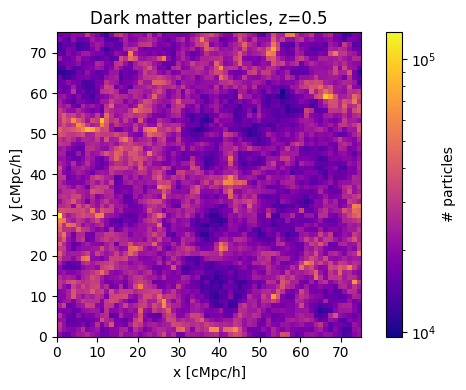

In [7]:
fig, ax = plt.subplots(figsize=(5.5,4))
_, _, _, im = ax.hist2d(dm_pos[:,0], dm_pos[:,1], cmap='plasma', norm=mpl.colors.LogNorm(), bins=64)
ax.set_xlim([0,75])
ax.set_ylim([0,75])
ticks = np.linspace(0, 70, 8)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_aspect('equal')
ax.set_xlabel('x [cMpc/h]')
ax.set_ylabel('y [cMpc/h]')
fig.colorbar(im, ax=ax, label='# particles')
ax.set_title('Dark matter particles, z=0.5')
fig.tight_layout()

### Compute 3D 2pt autocorrelation

In [8]:
# subsample 1/100th
dm_subsample = get_subsample(dm_pos, nx=100)

drawing 941963 random particles...


In [9]:
# parameters for Corrfunc
randmult = 3
rmin = 0.1
rmax = 20.
nbins = 20

In [12]:
%%time
ravg, xi = compute_3D_ls(dm_subsample, randmult, rmin, rmax, nbins, nthreads=24)

CPU times: user 14min 55s, sys: 272 ms, total: 14min 55s
Wall time: 37.6 s


In [13]:
# different subsample 1/50th
dm_subsample2 = get_subsample(dm_pos, nx=50)

drawing 1883927 random particles...


In [14]:
%%time
ravg, xi_full = compute_3D_ls(dm_subsample2, randmult, rmin, rmax, nbins, nthreads=24)

CPU times: user 1h 42s, sys: 616 ms, total: 1h 43s
Wall time: 2min 32s


Text(0.5, 1.0, '3D autocorrelation: DM particles')

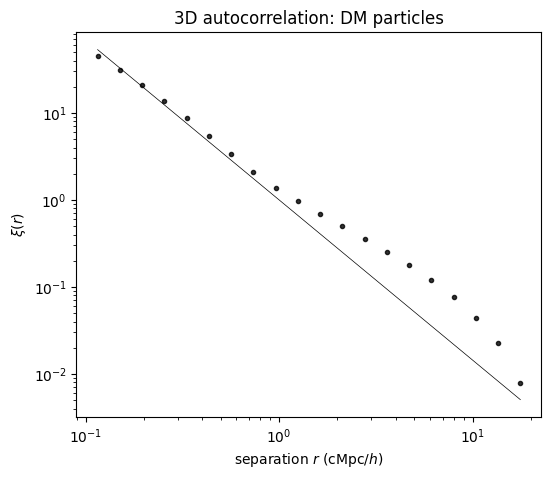

In [11]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(ravg, xi, color='k', marker='.', ls='None', alpha=0.8)
ax.plot(ravg, (ravg)**(-1.84), lw=0.5, color='k')

# ax.axhline(0, lw=0.5, color='k', alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim((1e-3,1e2))
ax.set_xlabel(r'separation $r$ (cMpc/$h$)')
ax.set_ylabel(r'$\xi (r)$')
ax.set_title(r'3D autocorrelation: DM particles')

### Compute projected (2D) 2pt autocorrelation

A bit about $w_p(r_p)$:

$r_p$ = projected separation between pairs

$\pi$ = line-of-sight separation between pairs;
only pairs with $\pi$ separation less than $\pi_\mathrm{max}$ are counted

In [12]:
pimax = 20.0  # distance to integrate along line of sight

In [14]:
rpavg, wp = compute_2D_ls(dm_subsample, randmult, rmin, rmax, nbins, pimax)

Text(0.5, 1.0, '2D projected autocorrelation: DM particles')

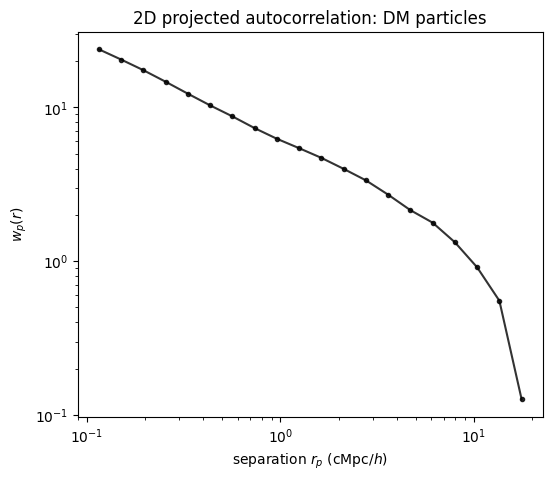

In [15]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(rpavg, wp, color='k', marker='.', ls='-', alpha=0.8)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r_p$ (cMpc/$h$)')
ax.set_ylabel(r'$w_p (r)$')
ax.set_title(r'2D projected autocorrelation: DM particles')

#### check that $\int \xi\ dr = \omega_p\ dr_p$

In [18]:
xi_int = trapz(results_xi['xi'], x=ravg)

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

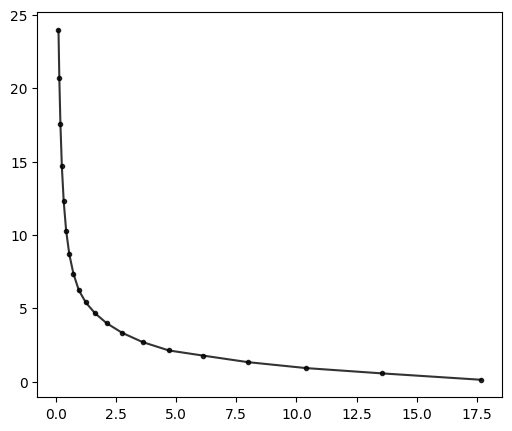

In [19]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(ravg, results_wp['wp'], color='k', marker='.', ls='-', alpha=0.8)
ax.plot(ravg, xi_int, 'k--', alpha=0.5)

# ax.axhline(0, color='k', lw=0.5, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r_p$ (cMpc/$h$)')
ax.set_ylabel(r'$\omega_p (r)$')
ax.set_title(r'2D projected autocorrelation: DM particles')